In [1]:
import numpy as np
import jax
from jax import jit, vmap, grad, random
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
from scipy.optimize import fsolve, root, bisect
import os 
if not os.path.exists('figures'):
    os.makedirs('figures')

%config InlineBackend.figure_format = 'retina'

sns.set_style('whitegrid')
!nvidia-smi

Wed Apr 17 22:58:01 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  | 00000000:E3:00.0 Off |                    0 |
| N/A   25C    P0              50W / 400W |      4MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [47]:
def df_1(etas, lamb):
  return jnp.mean(etas/(lamb+etas))

def df_1_bar(etas, lamb, sigma):
  return jnp.mean(etas/(lamb+etas)) + sigma**2/lamb

def df_2(etas, lamb):
  return jnp.mean((etas/(lamb+etas))**2)

def tf_1(etas, ws, lamb):
  return jnp.sum((ws**2) * etas/(lamb+etas))

def tf_1p(etas, ws, lamb):
  return jnp.sum((ws**2)*etas/(lamb+etas)**2)

def tf_2(etas, ws, lamb):
  return jnp.sum((ws**2) * etas**2/(lamb+etas)**2)

def newton(f, x0, max_step=100, abs_tol=1e-5, rel_tol=1e-10, eta=1.0):
    x = x0
    gf = grad(f)
    for _ in range(max_step):
        x_next = x - eta*f(x)/gf(x)
        if abs(f(x_next)) < abs_tol:
            return x_next
        x = x_next
    return None

def solve_kappa2(P,  Ns:list, lamb, etaX, sigma_xi=0.0, upper_bound=None, anneal_steps=1, **kwargs):
  if not upper_bound:
    upper_bound = lamb + 1e3
  D = Ns[0]
  if lamb == 0:
    if D == min(P, *Ns):
      return 0
    elif P == min(P, *Ns):
      fn = lambda kappa: 1 - D/P * df_1_bar(etaX, kappa, sigma_xi)
    else:
      N = min(Ns)
      fn = lambda kappa: N/D - df_1_bar(etaX, kappa, sigma_xi)
    return newton(fn, x0=0.0, **kwargs)
  
  def fn_lamb(kappa, lamb):
    ans = kappa * (1 - D/P * df_1_bar(etaX, kappa, sigma_xi))
    for N in Ns[1:]:
      ans *= N/D - df_1_bar(etaX, kappa, sigma_xi)
    return ans - lamb
  anneal_schedule = np.logspace(np.log10(lamb), 0, num=anneal_steps+1)[::-1]
  kappa = upper_bound
  for anneal_lamb in anneal_schedule:
    fn = lambda kappa: fn_lamb(kappa, anneal_lamb)
    kappa_next = newton(fn, x0=kappa, **kwargs)
    if not kappa_next: 
      print("Annealing didn't find kappa. Returning last value.")
      return kappa
    kappa = kappa_next
  return kappa

def estimate_df1_S(lamb, X_tr, FX_tr):
  P, D = X_tr.shape
  N = FX_tr.shape[1]
  q = D/P
  if q >= 1:
    gram = FX_tr @ FX_tr.T / P
    df1 = jnp.trace(jnp.linalg.inv(gram + lamb*np.identity(P)) @ gram)/D
    S = (lamb * jnp.trace(jnp.linalg.inv(gram + lamb*np.identity(P)))/P)**(-1)
    return df1, S
    
  else:
    cov = FX_tr.T @ FX_tr / P
    df1 = jnp.trace(jnp.linalg.inv(cov + lamb*np.identity(N)) @ cov)/D
    S = 1/(1-q * df1)
    return df1, S

def cantor_pairing(i, j):
  return (i + j) * (i + j + 1) // 2 + j


In [81]:
def simulate_theory(Ns, qs, lambs, sigma_epsilons, sigma_xis, X_spec, F_specs, teacher, X_te, Xi_te, y_te, num_X_seeds, num_F_seeds):
    if type(lambs) != list:
        lambs = [lambs]*len(qs)
    if type(sigma_epsilons) != list:
        sigma_epsilons = [sigma_epsilons]*len(qs)
    if type(sigma_xis) != list:
        sigma_xis = [sigma_xis]*len(qs)
    data = {}
    L = len(Ns)
    D = Ns[0]
    N = Ns[-1]
    Ss = [jnp.diag(X_spec)]
    for F_spec in F_specs:
        Ss.append(jnp.diag(F_spec))        
    w = teacher
    for i in tqdm(range(len(qs))):
        q, lamb, sigma_epsilon, sigma_xi = qs[i], lambs[i], sigma_epsilons[i], sigma_xis[i]
        P = int(D/q)
        y_hats = np.zeros((num_X_seeds, num_F_seeds, X_te.shape[0]))
        y_hats_clean = np.zeros((num_X_seeds, num_F_seeds, X_te.shape[0]))
        df1_empirical = np.zeros((num_X_seeds, num_F_seeds))
        kappa_GCV = np.zeros((num_X_seeds, num_F_seeds))
        Etrs = np.zeros((num_X_seeds, num_F_seeds))
        for X_seed in range(num_X_seeds):
            X_key = random.PRNGKey(X_seed)
            X_tr_key, e_key= random.split(X_key)
            epsilon = random.normal(e_key, (P, )) * sigma_epsilon
            X_tr = random.normal(X_tr_key, (P, D)) @ jnp.sqrt(Ss[0])
            y_tr = X_tr @ w + epsilon
            y_tr_clean = X_tr @ w

            for F_seed in range(num_F_seeds):
                F_key = random.PRNGKey(F_seed)
                Xi_key = random.PRNGKey(cantor_pairing(X_seed, F_seed))
                F_keys = random.split(F_key, L)
                F = jnp.identity(D)
                for l in range(1, L):
                    F_l = random.normal(F_keys[l], (Ns[l-1], Ns[l])) @ jnp.sqrt(Ss[l])/np.sqrt(D)
                    F = F @ F_l
                Xi = random.normal(Xi_key, (P, N)) * sigma_xi
                FX_tr = (X_tr @ F + Xi)
                FX_te = (X_te @ F + Xi_te)
                            
                if P > D:
                    cov = FX_tr.T @ FX_tr / P
                    w_star = jnp.linalg.solve(cov + lamb*np.identity(N), FX_tr.T @ y_tr / P)
                    w_star_clean = jnp.linalg.solve(FX_tr.T @ FX_tr + lamb*np.identity(N), FX_tr.T @ y_tr_clean)
                    y_hat_tr = FX_tr @ w_star
                    Etrs[X_seed, F_seed] = jnp.mean((y_tr - y_hat_tr)**2)
                else: 
                    gram = FX_tr @ FX_tr.T / P
                    w_star = FX_tr.T @ jnp.linalg.solve(gram + lamb*np.identity(P), y_tr) / P
                    w_star_clean = FX_tr.T @ jnp.linalg.solve(gram + lamb*np.identity(P), y_tr_clean) / P
                    Etrs[X_seed, F_seed] = lamb**2/P * jnp.sum((jnp.linalg.solve(gram + lamb*np.identity(P),  y_tr))**2)

                y_hats[X_seed, F_seed, :] = FX_te @ w_star
                y_hats_clean[X_seed, F_seed, :] = FX_te @ w_star_clean
                    
                df1_emp, S_emp = estimate_df1_S(lamb, X_tr, FX_tr)
                df1_empirical[X_seed, F_seed] = df1_emp
                kappa_GCV[X_seed, F_seed] = lamb * S_emp

        Eg = np.mean((y_hats - y_te[None, None, :])**2, axis=-1)
        Signal = np.mean((y_hats_clean - y_te[None, None, :])**2, axis=-1)
        Noise = np.mean((y_hats - y_hats_clean)**2, axis=-1)
        Bias =  np.mean((y_te - np.mean(y_hats_clean, axis=(0, 1)))**2)
        VarX = np.mean((jnp.mean(y_hats_clean, axis=1) - y_te[None, :])**2, axis=-1) - Bias
        VarF = np.mean((jnp.mean(y_hats_clean, axis=0) - y_te[None, :])**2, axis=-1) - Bias
        VarXF =  Signal - VarX - VarF - Bias
        VarXe = jnp.mean((jnp.mean(y_hats - y_hats_clean, axis=1))**2, axis=-1)
        VarXFe = Noise - VarXe
        data[q] = {
            'Eg': np.mean(Eg),
            'Eg_std': np.std(Eg),
            'Signal': np.mean(Signal),
            'Signal_std': np.std(Signal),
            'Noise': np.mean(Noise),
            'Noise_std': np.std(Noise),
            'Bias': Bias,
            'VarX': np.mean(VarX),
            'VarX_std': np.std(VarX),
            'VarF': np.mean(VarF),
            'VarF_std': np.std(VarF),
            'VarXF': np.mean(VarXF),
            'VarXF_std': np.std(VarXF),
            'VarXe': np.mean(VarXe),
            'VarXe_std': np.std(VarXe),
            'VarXFe': np.mean(VarXFe),
            'VarXFe_std': np.std(VarXFe),
            'Etr': np.mean(Etrs),
            'Etr_std': np.std(Etrs),
            'df1': np.mean(df1_empirical),
            'df1_std': np.std(df1_empirical),
            'kappa_GCV': np.mean(kappa_GCV),
            'kappa_GCV_std': np.std(kappa_GCV)
        }
        data[q]

    dataT = {}
    for key in data[qs[0]]:
        dataT[key] = np.array([data[q][key] for q in data])
    return dataT
    

def solve_theory(Ns, qs, lambs, sigma_epsilons, sigma_xis, X_spec, F_spec, teacher, anneal_steps=0, **kwargs):
    if type(lambs) != list:
        lambs = np.array([lambs]*len(qs))
    if type(sigma_epsilons) != list:
        sigma_epsilons = np.array([sigma_epsilons]*len(qs))
    if type(sigma_xis) != list:
        sigma_xis = np.array([sigma_xis]*len(qs))
    D = Ns[0]
    kappa2 = jnp.array([
        solve_kappa2(D/q, Ns, lamb=lamb, etaX=X_spec, sigma_xi=sx, anneal_steps=anneal_steps, **kwargs)
          for lamb, q, sx in zip(lambs, qs, sigma_xis)])
    df1k2 = jnp.array([df_1_bar(X_spec, k, sx) for k, sx in zip(kappa2, sigma_xis)])
    df2k2 = jnp.array([df_2(X_spec, k) for k in kappa2])
    tf1pk2 = jnp.array([tf_1p(X_spec, teacher, k) for k in kappa2])
    tf1k2 = jnp.array([tf_1(X_spec, teacher, k) for k in kappa2])
    tf2k2 = jnp.array([tf_2(X_spec, teacher, k) for k in kappa2])
    gamma2 = qs * df2k2
    kappa1 = kappa2
    for N in Ns[1:]:
        kappa1 *= (N/D - df1k2)
    dlogS = 0
    for N in Ns[1:]:
        dlogS += df1k2/(N/D - df1k2)
    dlogk1k2 = 1 + (df1k2-df2k2)/df1k2 * dlogS
    dlogk2k1 = 1/dlogk1k2
    gamma1 = qs * df1k2 * (1 - (df1k2 - df2k2)/df1k2 * dlogk2k1)
    
    signal = (kappa2**2 * tf1pk2 * dlogk2k1 + kappa2*tf1k2 * ( 1 - dlogk2k1) ) /(1-gamma1)
    noise = sigma_epsilons**2 * gamma1/(1-gamma1)
    bias = kappa2**2 * tf1pk2
    varX = kappa2**2 * tf1pk2 * gamma2/(1-gamma2)
    varXe = sigma_epsilons**2 * gamma2/(1-gamma2)
    varXFe = noise - varXe
    varF = (1 - dlogk2k1) * kappa2 * tf2k2
    varXF = signal - varX - varF - bias
    Eg = signal + noise
    Etr = ((lambs/kappa1)**2)*(Eg + sigma_epsilons**2)
    data = {
        'kappa2': kappa2,
        'kappa1': kappa1,
        'df1k2': df1k2,
        'df2k2': df2k2,
        'tf1pk2': tf1pk2,
        'tf1k2': tf1k2,
        'tf2k2': tf2k2,
        'dlogS': dlogS,
        'dlogk2k1': dlogk2k1,
        'dlogk1k2': dlogk1k2,
        'gamma1': gamma1,
        'gamma2': gamma2,
        'Bias': bias,
        'VarX': varX,
        'VarF': varF,
        'VarXF': varXF,
        'VarXe': varXe,
        'VarXFe': varXFe,
        'Noise': noise,
        'Signal': signal,
        'Eg': Eg,
        'Etr': Etr
    }
    return data

In [84]:
qs = np.logspace(-2, 2, 20)
P_te = 200
sigma_epsilon = 0.25
sigma_xi = 0.5

D = 200
N = 100
num_F_seeds = 5
num_X_seeds = 5

lamb = 1e-3

etasX = jnp.arange(1, D+1)**(-0.0)
etasF = jnp.arange(1, N+1)**(-0.0)
SX = jnp.diag(etasX)
w = jnp.arange(1, D+1)**(-0.0)
w = w / jnp.sqrt(jnp.sum(w**2))

X_te_key, Xi_te_key = random.split(random.PRNGKey(0))
X_te = random.normal(X_te_key, (P_te, D)) @ jnp.sqrt(SX)
Xi_te = random.normal(Xi_te_key, (P_te, N)) * sigma_xi
y_te = X_te @ w


expt = simulate_theory([D, N], qs, lamb, sigma_epsilon, sigma_xi, etasX, [etasF], w, X_te, Xi_te, y_te, num_X_seeds, num_F_seeds)

qs2 = qs
thry = solve_theory([D, N], qs2, lamb, sigma_epsilon, sigma_xi, etasX, [etasF], w, anneal_steps=4)


100%|██████████| 20/20 [00:03<00:00,  5.96it/s]


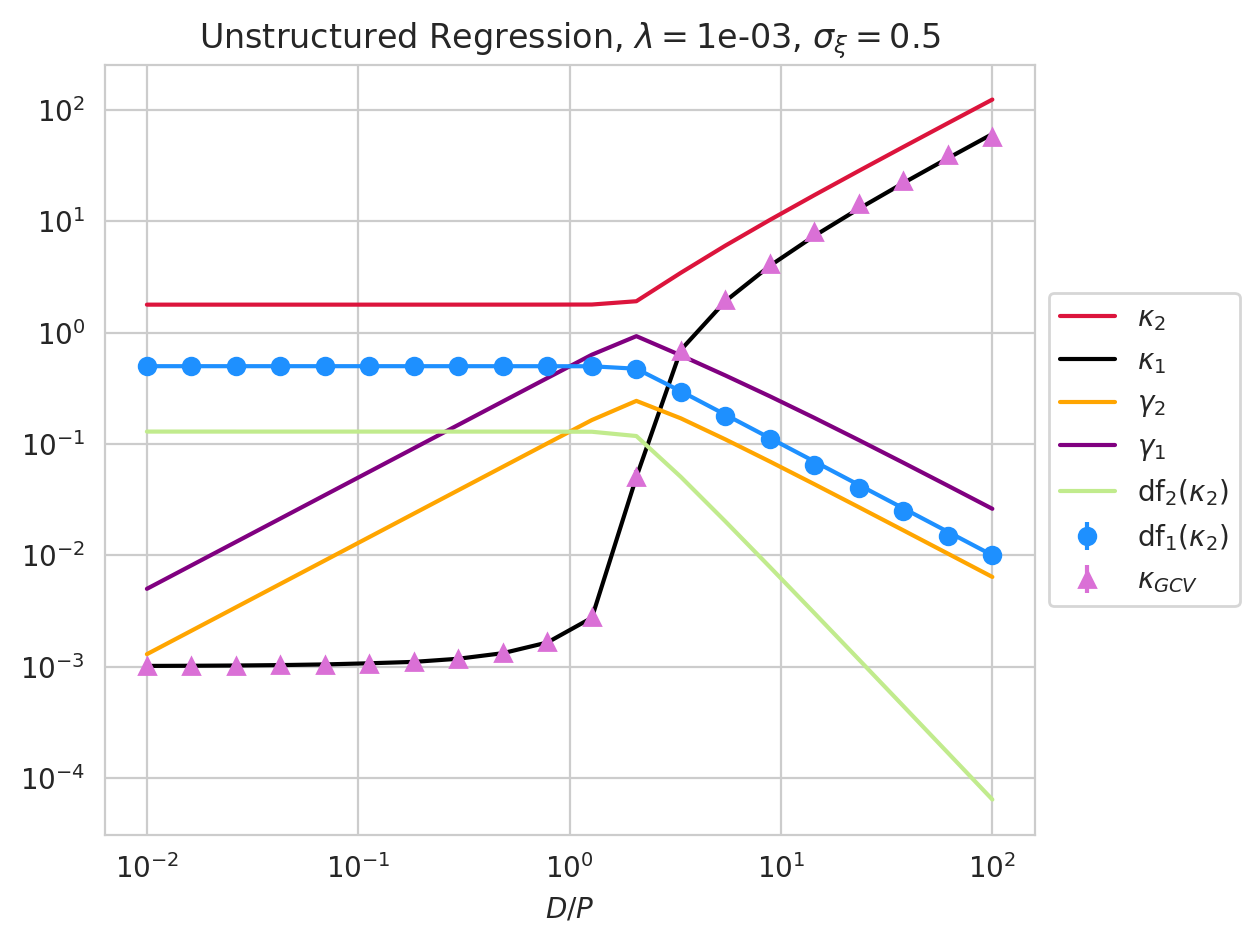

In [85]:
sns.set_palette('rainbow', n_colors=7)
plt.figure(figsize=(6, 5))
plt.plot(qs2, thry['kappa2'], label="$\\kappa_2$", c='crimson')
plt.plot(qs2, thry['kappa1'], label="$\\kappa_1$", c='k')
plt.plot(qs2, thry['gamma2'], label="$\\gamma_2$", c='orange')
plt.plot(qs2, thry['gamma1'], label="$\\gamma_1$", c='purple')
plt.plot(qs2, thry['df1k2'],  c='dodgerblue')
plt.errorbar(qs2, expt['df1'], expt['df1_std'], marker='o', linestyle="", label="df$_1(\\kappa_2)$", c='dodgerblue')
plt.plot(qs2, thry['df2k2'], label="df$_2(\\kappa_2)$", c='C4')

plt.errorbar(qs, expt['kappa_GCV'], expt['kappa_GCV_std'], label="$\\kappa_{GCV}$", c='orchid', marker='^', linestyle="")

# ps = D/qs
# gams = np.minimum(N, ps)/D
# kappa2_analytic = (1-gams + sigma_xi**2 + np.sqrt( (1-gams+ sigma_xi**2)**2 + 4 * gams  * sigma_xi**2 ))/(2 * gams)
# df1b_analytic = 1/(1+kappa2_analytic) + (sigma_xi**2)/kappa2_analytic
# df2_analytic =  1/(1+kappa2_analytic)**2
# df1_analytic =  1/(1+kappa2_analytic)

# plt.plot(qs, kappa2_analytic, label="$\\kappa_1$_a", c='k', linestyle='--')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$D/P$')
plt.title(f"Unstructured Regression, $\\lambda=${lamb:.0e}, $\\sigma_{{\\xi}}=${sigma_xi}")
plt.savefig('figures/NLRF_unstructured_params.pdf', bbox_inches='tight')

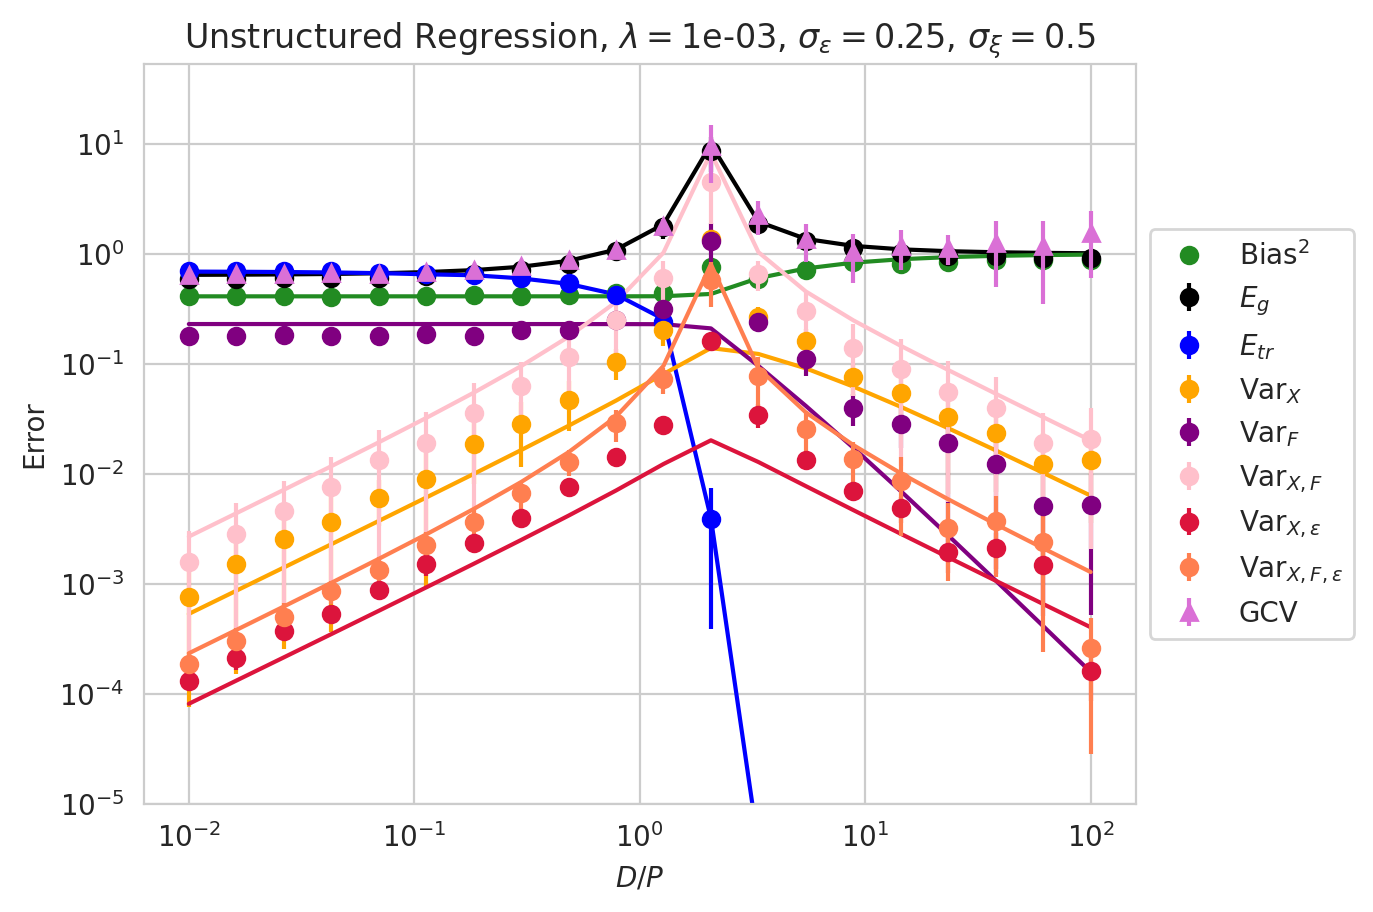

In [86]:
keys = ['Eg', 'Etr', 'Bias', 'VarX', 'VarF', 'VarXF', 'VarXe', 'VarXFe']
colors = ['k', 'b', 'forestgreen', 'orange', 'purple', 'pink', 'crimson', 'coral']
labels = ["$E_g$", "$E_{tr}$", "Bias$^2$", "Var$_X$", "Var$_F$", "Var$_{{X, F}}$", "Var$_{{X, \\epsilon}}$", "Var$_{{X, F, \\epsilon}}$"]
for i in range(len(keys)):
    key, color, label = keys[i], colors[i], labels[i]
    if key+'_std' in expt:
        plt.errorbar(qs, expt[key], np.minimum(expt[key+'_std'], expt[key]*0.9),  c=color, marker='o', linestyle='', label=label)
    else:
        plt.plot(qs, expt[key], c=color, marker='o', linestyle='', label=label)
    plt.plot(qs2, thry[key], c=color)

E_GCV = (expt['kappa_GCV']/lamb)**2 * expt['Etr'] - sigma_epsilon**2
E_GCV_std = (expt['kappa_GCV']/lamb)**2 * expt['Etr_std']
E_GCV_std = np.where(E_GCV_std > E_GCV, E_GCV_std/2, E_GCV_std)
plt.errorbar(qs, E_GCV,  E_GCV_std/1.2, c='orchid', marker='^', linestyle='', label='GCV', zorder=3)

plt.xlabel(r'$D/P$')
plt.ylabel('Error')
plt.xscale('log')
plt.yscale('log')
plt.ylim(bottom=1e-5, top=None)
plt.title(f"Unstructured Regression, $\\lambda=${lamb:.0e}, $\\sigma_\\epsilon=${sigma_epsilon}, $\\sigma_\\xi=${sigma_xi}")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.savefig('figures/unstructured_LRF.pdf', bbox_inches='tight')

## Structured

In [112]:
qs = np.logspace(1, 4, 10)
P_te = 200

lamb=1e-6

D = 10_000
N = 1000
num_F_seeds = 5
num_X_seeds = 5

sigma_epsilon = 0
sigma_xi = np.sqrt(1/N)

alpha1 = 1.5
alpha2 = 0.0
a = 4.5
etasX = jnp.arange(1, D+1)**(-alpha1)
etasF = jnp.arange(1, N+1)**(-alpha2)
SX = jnp.diag(etasX)
w = jnp.arange(1, D+1)**(-(a-alpha1)/2)
w = w# / jnp.sqrt(jnp.sum(w**2))

X_te_key, Xi_te_key = random.split(random.PRNGKey(0))
X_te = random.normal(X_te_key, (P_te, D)) @ jnp.sqrt(SX)
Xi_te = random.normal(Xi_te_key, (P_te, N)) * sigma_xi
y_te = X_te @ w

expt = simulate_theory([D, N], qs, lamb, sigma_epsilon, sigma_xi, etasX, [etasF], w, X_te, Xi_te, y_te, num_X_seeds, num_F_seeds)

qs2 = qs
thry = solve_theory([D, N], qs2, lamb, sigma_epsilon, sigma_xi, etasX, [etasF], w, anneal_steps=6)


100%|██████████| 10/10 [00:02<00:00,  3.67it/s]


Text(0.5, 1.0, 'Structured Regression, $D=10000, N=1000$\n$a=$4.5, $b_1=$1.5 $\\lambda=$1e-06')

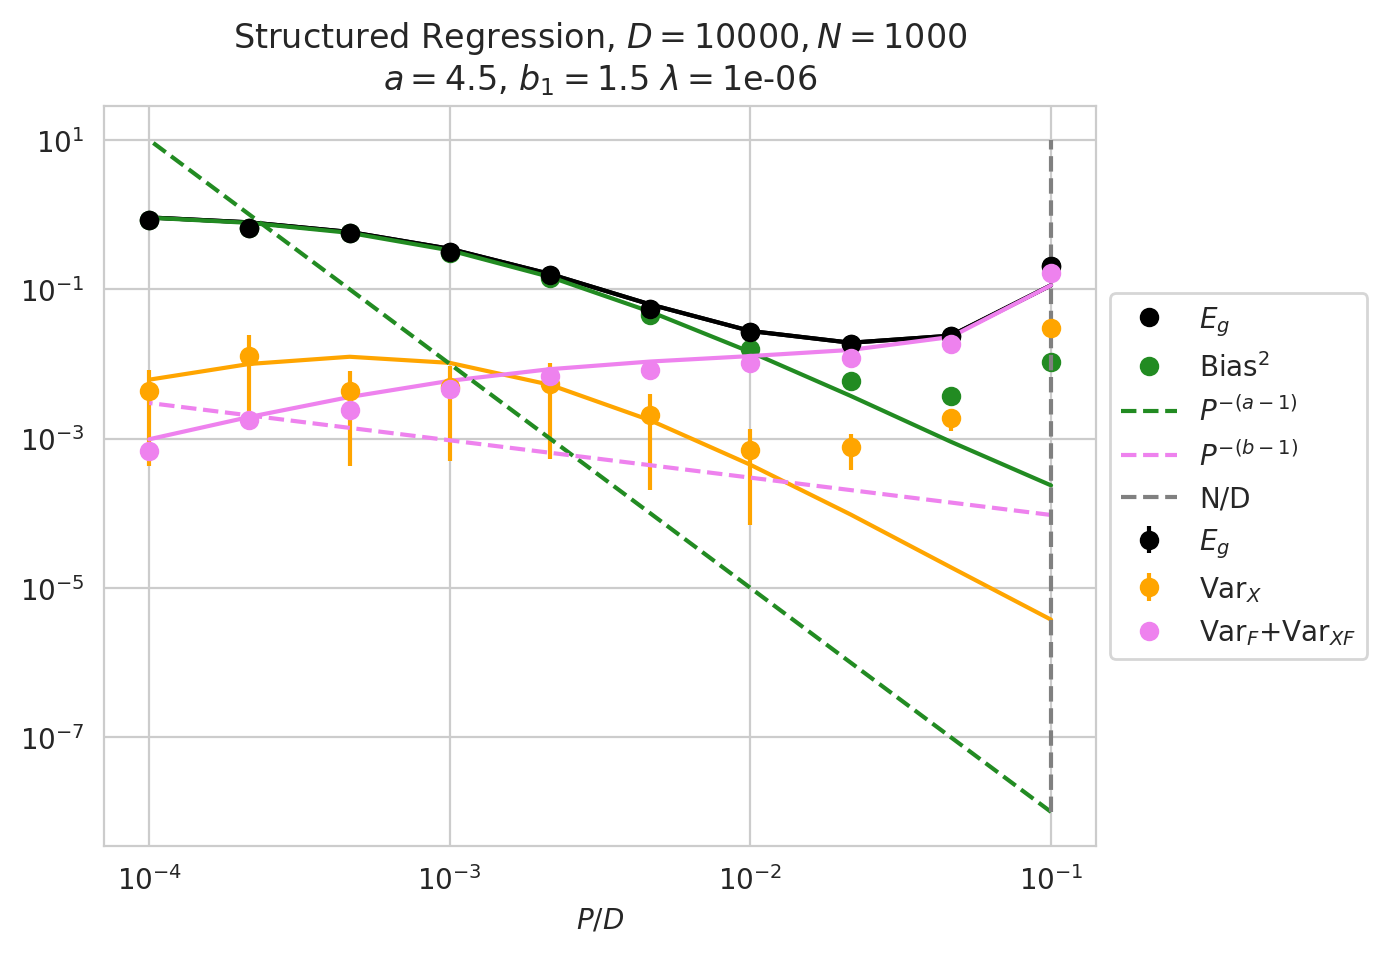

In [113]:
plt.loglog(1/qs, expt['Eg'], c='k', marker='o', ls='', label="$E_g$")
plt.loglog(1/qs2, thry['Eg'], c='k')

keys = ['Eg', 'Etr', 'Bias', 'VarX', 'VarF', 'VarXF']
colors = ['k', 'b', 'forestgreen', 'orange', 'purple', 'pink']
labels = ["$E_g$", "$E_{tr}$", "Bias$^2$", "Var$_X$", "Var$_F$", "Var$_{{X, F}}$"]
for i in range(len(keys)):
    if i in [1, 4, 5]: continue
    key, color, label = keys[i], colors[i], labels[i]
    if key+'_std' in expt:
        plt.errorbar(1/qs, expt[key], np.minimum(expt[key+'_std'], expt[key]*0.9),  c=color, marker='o', linestyle='', label=label)
    else:
        plt.plot(1/qs, expt[key], c=color, marker='o', linestyle='', label=label)
    plt.plot(1/qs2, thry[key], c=color)

plt.errorbar(1/qs, expt["VarF"] + expt["VarXF"], ls="", marker='o', c='violet', label="Var$_F$+Var$_{{XF}}$")
plt.plot(1/qs2, thry['VarF']+thry['VarXF'], c='violet')

plt.plot(1/qs2, 1e-11*qs2**(min(2*alpha1, a-1)), '--', c='forestgreen', label="$P^{{-(a-1)}}$")
plt.plot(1/qs2, 3e-5*qs2**(min(alpha1-1, a-1)), '--', c='violet', label="$P^{{-(b-1)}}$")


plt.plot([N/D, N/D], [1e-8, 1e1], linestyle='--', color='grey', label="N/D")
# plt.ylim(bottom=1e-5, top=2e0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel(r'$P/D$')
plt.title(f"Structured Regression, $D={D}, N={N}$\n$a=${a}, $b_1=${alpha1} $\\lambda=${lamb:.0e}")
